# ECE 498 DS Mini Project 2 - Template

# schyu2, manukov2, jjchan3

# Task 1: Data Cleaning and Visual Inspection

## 0. Getting Started With the Data

### 1. With increased samples, biologists can apply the central limit theorum to the population mean of microbe abundance. This is required versus only taking few samples, because us a sample may happen to be an exteme under the population distribution, resulting in the analyzed and concluded population mean being very far from the truth.

In [4]:
import pandas as pd #importing pandas
RelativeAbundance_HE0Df = pd.read_csv("RelativeAbundance_HE0.csv") #importing the dataset
RelativeAbundance_HE1Df = pd.read_csv("RelativeAbundance_HE1.csv") #importing the dataset

In [5]:
# Getting the number of rows(microbes) and columns(1 + number of samples)
print(RelativeAbundance_HE0Df.shape[0])
print(RelativeAbundance_HE0Df.shape[1])

149
765


### 2. There are 764 samples analyzed. ( = ncolumns - 1 b/c one column is occupied by microbe names)

### 3. There are 149 microbes identified.

## 1. Bayesian Network for Quality Control

### a. Joint Probability Factorization :

P(Quality, Contamination, Lab Time Before Processing, Collection Method, Storage Temp) 

= P(Quality | Contamination, Lab Time Before Processing, Collection Method, Storage Temp) * P(Contamination | Lab Time Before Processing, Collection Method, Storage Temp) * P(Lab Time Before Processing| Collection Method, Storage Temp) * P(Collection Method | Storage Temp) * P(Storage Temp)  

= P(Quality|Contamination, Lab Time Before Processing) P(Contamination | Collection Method, Storage Temp) * P(Lab Time Before Processing) * P(Collection Method) * P(Storage Temp)

### b. Parameters Required

Because the joint distribution can be written as: 
P(Quality|Contamination, Lab Time Before Processing) P(Contamination | Collection Method, Storage Temp) * P(Lab Time Before Processing) * P(Collection Method) * P(Storage Temp), where every variable is binomial, we will need 
4 + 4 + 1 + 1 + 1 = 11 parameters. 

### c. Constructing Probability Tables

In [6]:
QualityControlDf = pd.read_csv("QualityControl.csv")

In [7]:
QualityControlDf.head()

,strtmp,coll,labtime,cont,qual
0,cold,nurse,short,low,good
1,cold,nurse,short,low,good
2,cold,nurse,short,low,bad
3,cold,nurse,short,high,good
4,cold,nurse,short,low,good


In [8]:
def plabtime(labtime):
    return(len(QualityControlDf[QualityControlDf['labtime'] == labtime])/len(QualityControlDf))
P_LabTimeDf = pd.DataFrame()
P_LabTimeDf['LabTime'] = QualityControlDf['labtime'].unique()
P_LabTimeDf['P(LabTime)'] = P_LabTimeDf['LabTime'].apply(plabtime)
print(P_LabTimeDf)

def pcoll(coll):
    return(len(QualityControlDf[QualityControlDf['coll'] == coll])/len(QualityControlDf))
P_CollectionMethodDf = pd.DataFrame()
P_CollectionMethodDf['CollectionMethod'] = QualityControlDf['coll'].unique()
P_CollectionMethodDf['P(CollectionMethod)'] = P_CollectionMethodDf['CollectionMethod'].apply(pcoll)
print(P_CollectionMethodDf)

def pstoragetemp(strtmp):
    return(len(QualityControlDf[QualityControlDf['strtmp'] == strtmp])/len(QualityControlDf))
P_StorageTempDf = pd.DataFrame()
P_StorageTempDf['StorageTemp'] = QualityControlDf['strtmp'].unique()
P_StorageTempDf['P(StorageTemp)'] = P_StorageTempDf['StorageTemp'].apply(pstoragetemp)
print(P_StorageTempDf)

def pcontamination(cont, strtmp,coll):
    return(len(QualityControlDf[(QualityControlDf['cont'] == cont) & (QualityControlDf['strtmp'] == strtmp) & (QualityControlDf['coll'] == coll)])/len(QualityControlDf[(QualityControlDf['strtmp'] == strtmp) & (QualityControlDf['coll'] == coll)]))
combinations_for_cont = [('high','cold','nurse')
                ,('low','cold','nurse')
                ,('high', 'cool', 'nurse')
                ,('low', 'cool', 'nurse')
                ,('high','cold','patient')
                ,('low','cold','patient')
                ,('high', 'cool', 'patient')
                ,('low', 'cool', 'patient')]
P_ContaminationDf = pd.DataFrame(combinations_for_cont, columns=['Contamination', 'StorageTemp', 'CollectionMethod'])
P_ContaminationDf['P(Contamination|StorageTemp, CollectionMethod)'] = P_ContaminationDf.apply(lambda x: pcontamination(x.Contamination, x.StorageTemp, x.CollectionMethod), axis=1)
print(P_ContaminationDf)

def pquality(qual, cont,labtime):
    return(len(QualityControlDf[(QualityControlDf['qual'] == qual) & (QualityControlDf['cont'] == cont) & (QualityControlDf['labtime'] == labtime)])/len(QualityControlDf[(QualityControlDf['cont'] == cont) & (QualityControlDf['labtime'] == labtime)]))
combinations_for_qual = [('good','high','short')
                        ,('bad','high','short')
                        ,('good', 'low', 'short')
                        ,('bad', 'low', 'short')
                        ,('good','high','long')
                        ,('bad','high','long')
                        ,('good', 'low', 'long')
                        ,('bad', 'low', 'long')]
P_QualityDf = pd.DataFrame(combinations_for_qual, columns=['Quality', 'Contamination', 'LabTime'])
P_QualityDf['P(Quality|Contamination, LabTime)'] = P_QualityDf.apply(lambda x: pquality(x.Quality, x.Contamination, x.LabTime), axis=1)
print(P_QualityDf)


  LabTime  P(LabTime)
0   short      0.7956
1    long      0.2044
  CollectionMethod  P(CollectionMethod)
0            nurse               0.8976
1          patient               0.1024
  StorageTemp  P(StorageTemp)
0        cold          0.8982
1        cool          0.1018
  Contamination StorageTemp CollectionMethod  \
0          high        cold            nurse   
1           low        cold            nurse   
2          high        cool            nurse   
3           low        cool            nurse   
4          high        cold          patient   
5           low        cold          patient   
6          high        cool          patient   
7           low        cool          patient   

   P(Contamination|StorageTemp, CollectionMethod)  
0                                        0.043983  
1                                        0.956017  
2                                        0.088435  
3                                        0.911565  
4                              

### d. Final Probability Tables

In [9]:
# P(Qualtiy | Storage Temp , COllection Method, Labtime) =P (Qualtiy , Storage Temp , COllection Method, Labtime ) / P(Storage Temp , COllection Method, Labtime)


Combinations_final =  [('good','cold', 'nurse',   'short'),
                       ('bad', 'cold', 'nurse',   'short'),
                       ('good','cool', 'nurse',   'short'),
                       ('bad', 'cool', 'nurse',   'short'),
                       ('good','cold', 'patient', 'short'),
                       ('bad', 'cold', 'patient', 'short'),
                       ('good','cool', 'patient', 'short'),
                       ('bad', 'cool', 'patient', 'short'),
                       ('good','cold', 'nurse',   'long'),
                       ('bad', 'cold', 'nurse',   'long'),
                       ('good','cool', 'nurse',   'long'),
                       ('bad', 'cool', 'nurse',   'long'),
                       ('good','cold', 'patient', 'long'),
                       ('bad', 'cold', 'patient', 'long'),
                       ('good','cool', 'patient', 'long'),
                       ('bad', 'cool', 'patient', 'long')]
P_Final_Df = pd.DataFrame(Combinations_final, columns = ['Quality' , 'StorageTemp', 'CollectionMethod' , 'LabTime'])
def pfinal(qual, strtmp, coll, labtime):
    qualmask = QualityControlDf['qual'] == qual
    strtmpmask = QualityControlDf['strtmp'] == strtmp
    collmask = QualityControlDf['coll'] == coll
    labtimemask = QualityControlDf['labtime'] == labtime
    num = len(QualityControlDf[qualmask & strtmpmask & collmask & labtimemask])
    denom = len(QualityControlDf[strtmpmask & collmask & labtimemask])
    return(num/denom)
P_Final_Df['P(Quality|StorageTemp, CollectionMethod, LabTime)'] = P_Final_Df.apply(lambda x: pfinal(x.Quality, x.StorageTemp, x.CollectionMethod, x.LabTime), axis =1 )
print(P_Final_Df)

   Quality StorageTemp CollectionMethod LabTime  \
0     good        cold            nurse   short   
1      bad        cold            nurse   short   
2     good        cool            nurse   short   
3      bad        cool            nurse   short   
4     good        cold          patient   short   
5      bad        cold          patient   short   
6     good        cool          patient   short   
7      bad        cool          patient   short   
8     good        cold            nurse    long   
9      bad        cold            nurse    long   
10    good        cool            nurse    long   
11     bad        cool            nurse    long   
12    good        cold          patient    long   
13     bad        cold          patient    long   
14    good        cool          patient    long   
15     bad        cool          patient    long   

    P(Quality|StorageTemp, CollectionMethod, LabTime)  
0                                            0.955112  
1                   

### e. Cleaning the dataset

In [10]:
BayesInferenceHE0DF = pd.read_csv("BayesInferenceHE0.csv")
BayesInferenceHE1DF = pd.read_csv("BayesInferenceHE1.csv")

In [11]:
HE0_bad = []
for i in range(0,len(BayesInferenceHE0DF)):
    pgood = pfinal('good',BayesInferenceHE0DF['strtmp'][i],
                   BayesInferenceHE0DF['coll'][i],
                   BayesInferenceHE0DF['labtime'][i])
    pbad = pfinal('bad',BayesInferenceHE0DF['strtmp'][i],
                   BayesInferenceHE0DF['coll'][i],
                   BayesInferenceHE0DF['labtime'][i])
    if (pgood < pbad):
        HE0_bad.append(BayesInferenceHE0DF['SampleName'][i])

HE1_bad = []
for i in range(0,len(BayesInferenceHE1DF)):
    pgood = pfinal('good',BayesInferenceHE1DF['strtmp'][i],
                   BayesInferenceHE1DF['coll'][i],
                   BayesInferenceHE1DF['labtime'][i])
    pbad = pfinal('bad',BayesInferenceHE1DF['strtmp'][i],
                   BayesInferenceHE1DF['coll'][i],
                   BayesInferenceHE1DF['labtime'][i])
    if (pgood < pbad):
        HE1_bad.append(BayesInferenceHE1DF['SampleName'][i])

In [12]:
print('There are {} dropped rows from HE0_bad'.format(len(HE0_bad)))
for i in HE0_bad:
    BayesInferenceHE0DF = BayesInferenceHE0DF[(BayesInferenceHE0DF['SampleName'] != i)]
    if (i in RelativeAbundance_HE0Df.columns):
        del RelativeAbundance_HE0Df[i]
print('There are {} dropped rows from HE1_bad'.format(len(HE1_bad)))
for i in HE1_bad:
    BayesInferenceHE1DF = BayesInferenceHE1DF[(BayesInferenceHE1DF['SampleName'] != i)]
    if (i in RelativeAbundance_HE1Df.columns):
        del RelativeAbundance_HE1Df[i]


There are 65 dropped rows from HE0_bad
There are 65 dropped rows from HE1_bad


## 2. Data Standardization

### 1. Verify Relative Abundance

In [13]:
# This delta value is a placeholder in case it is required to have the column sum be within a delta value of 1.
delta = 10 ** -10

for i in RelativeAbundance_HE0Df.iloc[:, 1:]:
    col_sum = RelativeAbundance_HE0Df.loc[:][i].sum()
    
    # if the absolute difference between 1 and the column sum is greater than delta, discard the column
    if (abs(1 - col_sum) > delta):
        del RelativeAbundance_HE0Df[i]
        
display(RelativeAbundance_HE0Df)

for i in RelativeAbundance_HE1Df.iloc[:, 1:]:
    col_sum = RelativeAbundance_HE1Df.loc[:][i].sum()
    
    # if the absolute difference between 1 and the column sum is greater than delta, discard the column
    if (abs(1 - col_sum) > delta):
        del RelativeAbundance_HE1Df[i]
        
display(RelativeAbundance_HE1Df)

,Microbe Name,HE0Sample_0,HE0Sample_1,HE0Sample_2,HE0Sample_3,HE0Sample_4,HE0Sample_5,HE0Sample_6,HE0Sample_7,HE0Sample_8,...,HE0Sample_689,HE0Sample_690,HE0Sample_691,HE0Sample_692,HE0Sample_693,HE0Sample_694,HE0Sample_695,HE0Sample_696,HE0Sample_697,HE0Sample_698
0,Acidobacteria_Acidobacteria_Gp1_Telmatobacter_...,0.004239,0.004345,0.004423,0.004463,0.005372,0.004136,0.004457,0.004049,0.004638,...,0.004681,0.005588,0.004256,0.003755,0.004995,0.006198,0.006096,0.003961,0.003970,0.005229
1,Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3,0.013269,0.012312,0.011611,0.013033,0.013689,0.012752,0.009772,0.012148,0.013743,...,0.007489,0.011874,0.011103,0.014661,0.009301,0.010331,0.012716,0.011195,0.011731,0.014642
2,Actinobacteria_Actinobacteria_Acidimicrobiales...,0.003502,0.005251,0.006082,0.003749,0.004332,0.004136,0.004972,0.004930,0.004638,...,0.005055,0.002095,0.005736,0.004291,0.006545,0.004132,0.004877,0.004823,0.001985,0.004532
3,Actinobacteria_Actinobacteria_Actinomycetales_...,0.003870,0.005794,0.005345,0.004106,0.002946,0.003963,0.005315,0.003697,0.005326,...,0.004306,0.003318,0.004626,0.004112,0.004823,0.005447,0.004877,0.003961,0.003609,0.003486
4,Actinobacteria_Actinobacteria_Actinomycetales_...,0.004976,0.003802,0.004239,0.004285,0.005198,0.004136,0.003257,0.002993,0.003264,...,0.005242,0.002445,0.005736,0.005006,0.004306,0.004884,0.002613,0.004650,0.005234,0.004183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,Tenericutes_Mollicutes_Anaeroplasmatales_Anaer...,0.004792,0.003983,0.004976,0.004285,0.003985,0.003963,0.003429,0.005458,0.005154,...,0.003370,0.005762,0.003516,0.004291,0.005167,0.004508,0.002961,0.005512,0.003970,0.003486
145,Tenericutes_Mollicutes_Haloplasmatales_Halopla...,0.004976,0.004345,0.004792,0.007499,0.004332,0.003274,0.004286,0.004930,0.003951,...,0.004306,0.003143,0.003516,0.005364,0.003445,0.005447,0.004355,0.004306,0.005414,0.003660
146,Tenericutes_Mollicutes_Mycoplasmatales_Mycopla...,0.013638,0.010139,0.011611,0.010891,0.009184,0.009478,0.013544,0.014261,0.012541,...,0.014604,0.011524,0.013138,0.013231,0.008612,0.010706,0.010625,0.009645,0.012272,0.008192
147,Thermodesulfobacteria_Thermodesulfobacteria_Th...,0.003870,0.003802,0.004423,0.003571,0.004159,0.004825,0.004972,0.003345,0.004810,...,0.006366,0.004365,0.004626,0.004827,0.005856,0.003757,0.004180,0.002756,0.004512,0.004009


,Microbe Name,HE1Sample_0,HE1Sample_1,HE1Sample_2,HE1Sample_3,HE1Sample_4,HE1Sample_5,HE1Sample_6,HE1Sample_7,HE1Sample_8,...,HE1Sample_689,HE1Sample_690,HE1Sample_691,HE1Sample_692,HE1Sample_693,HE1Sample_694,HE1Sample_695,HE1Sample_696,HE1Sample_697,HE1Sample_698
0,Acidobacteria_Acidobacteria_Gp1_Telmatobacter_...,0.004864,0.004041,0.005630,0.005046,0.005041,0.005278,0.004005,0.003700,0.004295,...,0.005573,0.004854,0.005412,0.004985,0.004070,0.003940,0.003880,0.004454,0.003743,0.005301
1,Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3,0.011985,0.012124,0.010732,0.012074,0.009001,0.012559,0.013234,0.011284,0.011391,...,0.010786,0.011963,0.011571,0.010657,0.013136,0.009381,0.012875,0.009280,0.010479,0.009322
2,Actinobacteria_Actinobacteria_Acidimicrobiales...,0.005211,0.003866,0.004926,0.004505,0.005401,0.005461,0.005050,0.003330,0.003922,...,0.004494,0.004508,0.002613,0.005672,0.003330,0.005253,0.004409,0.005011,0.005801,0.005301
3,Actinobacteria_Actinobacteria_Actinomycetales_...,0.003995,0.003866,0.004046,0.005406,0.003600,0.006189,0.003308,0.004255,0.004482,...,0.004494,0.005721,0.004479,0.002922,0.005365,0.004503,0.003527,0.005568,0.004304,0.006946
4,Actinobacteria_Actinobacteria_Actinomycetales_...,0.002953,0.003514,0.004574,0.005046,0.003420,0.004186,0.004701,0.004624,0.003361,...,0.002876,0.003467,0.004479,0.002922,0.003885,0.004690,0.004233,0.006496,0.003743,0.006215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,Tenericutes_Mollicutes_Anaeroplasmatales_Anaer...,0.005211,0.004920,0.004750,0.004505,0.004320,0.004004,0.004701,0.005734,0.003922,...,0.004674,0.003988,0.005226,0.004641,0.005180,0.004878,0.004056,0.005197,0.005801,0.003838
145,Tenericutes_Mollicutes_Haloplasmatales_Halopla...,0.002953,0.004744,0.002463,0.005226,0.003960,0.004186,0.003657,0.004070,0.004482,...,0.003775,0.005028,0.002986,0.005156,0.005180,0.003752,0.005644,0.004640,0.005988,0.005483
146,Tenericutes_Mollicutes_Mycoplasmatales_Mycopla...,0.012507,0.009840,0.010204,0.010993,0.011161,0.009829,0.012711,0.012394,0.007656,...,0.011145,0.011096,0.009518,0.012204,0.013321,0.008068,0.014286,0.012992,0.010292,0.009687
147,Thermodesulfobacteria_Thermodesulfobacteria_Th...,0.005906,0.004217,0.005102,0.004505,0.003420,0.006189,0.004179,0.004070,0.004482,...,0.003236,0.004854,0.002240,0.003266,0.003885,0.004690,0.003880,0.004083,0.005052,0.005118


### 2. Discussion on Relative Abundance Data

A benefit of using relative abundance data is so that analysis is not skewed by the units of each sample. It's possible that the amounts of a particular microbe are very different between two samples while the relative abundances of that microbe is not that much different. The sample with a greater amount of the microbe may have greater effect in data analysis than the other sample which may not be ideal. 

A drawback of using relative abundance data is that you lose the units of each microbe in samples. If a condition occurs when a certain amount of microbe is present in a sample, it would not be able to detected since the data does not provide how much of a microbe is in each sample.

There is information loss during normalization. As stated earlier, you lose track how much of each microbe was found in each sample.

## 3. Visual Inspection

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

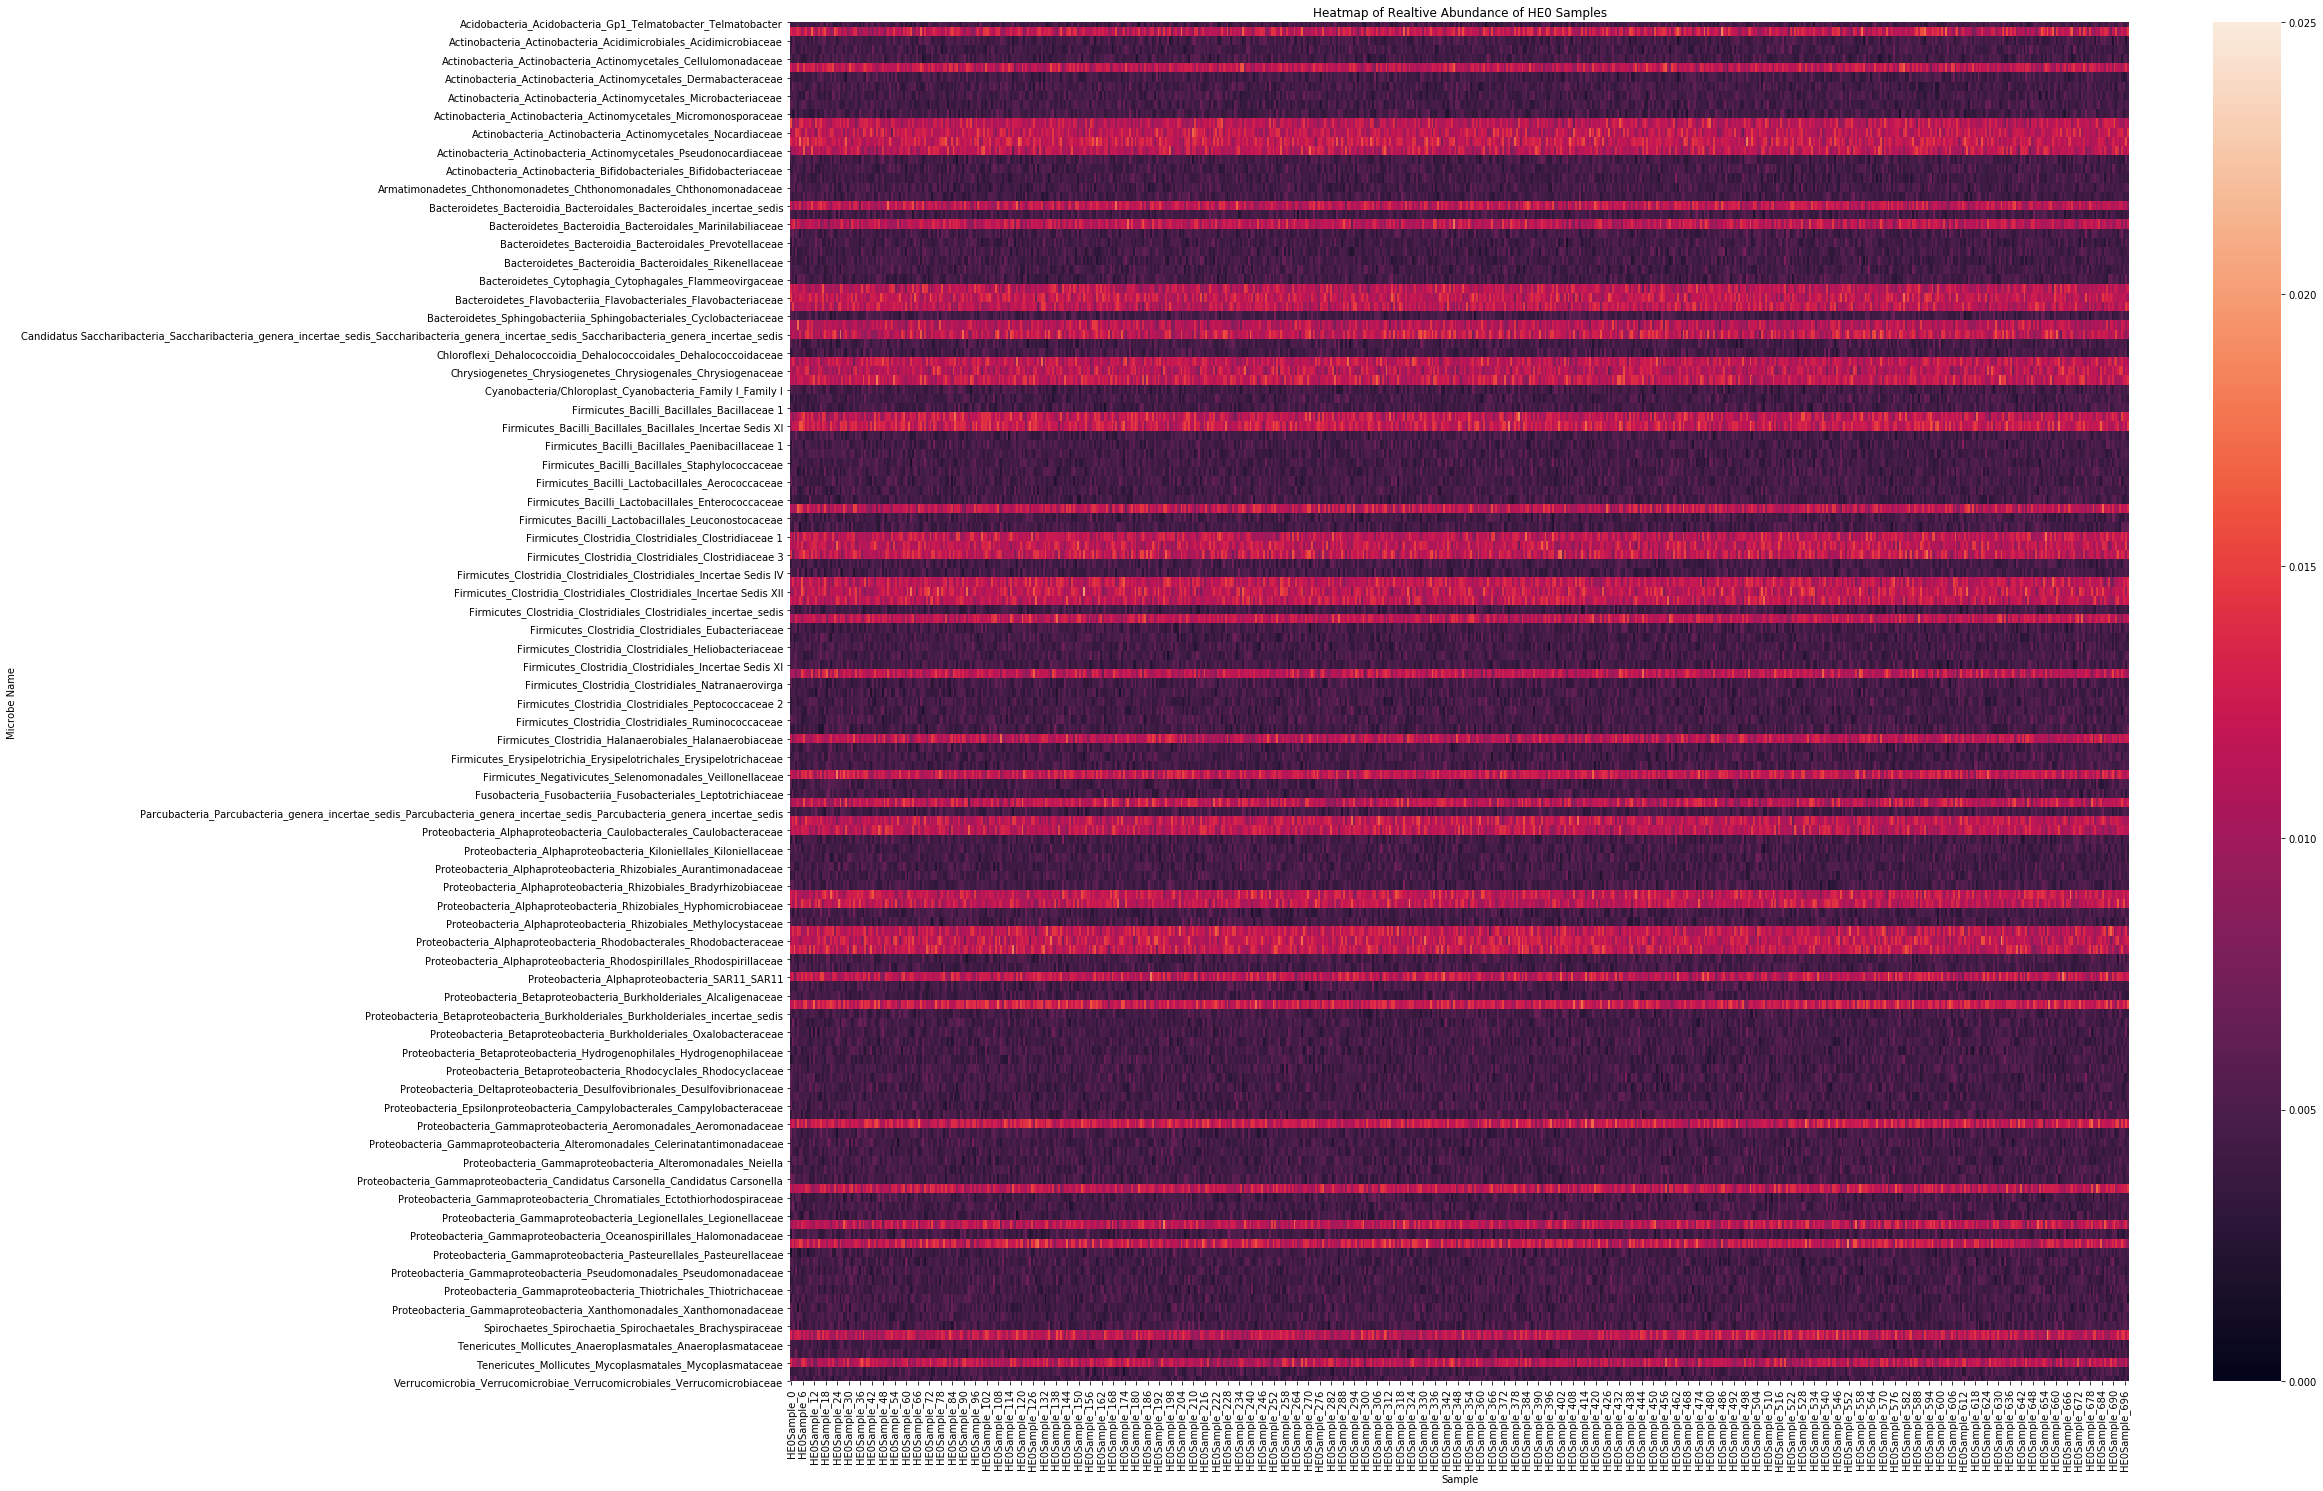

In [20]:
# Plot heatmap for HE0 samples

fig1, ax1 = plt.subplots(figsize = (30, 25))
sns.heatmap(RelativeAbundance_HE0Df.set_index("Microbe Name"), vmin = 0, vmax = 0.025)
#sns.heatmap(RelativeAbundance_HE0Df.iloc[:, 1:].transpose(), vmin = 0, vmax = 0.025, xticklabels = RelativeAbundance_HE0Df["Microbe Name"], ax = ax1)
ax1.set_title("Heatmap of Realtive Abundance of HE0 Samples")
ax1.set_ylabel("Microbe Name")
ax1.set_xlabel("Sample")

# Save plot to image file
plt.savefig("RelativeAbundanceHE0_Heatmap.png")

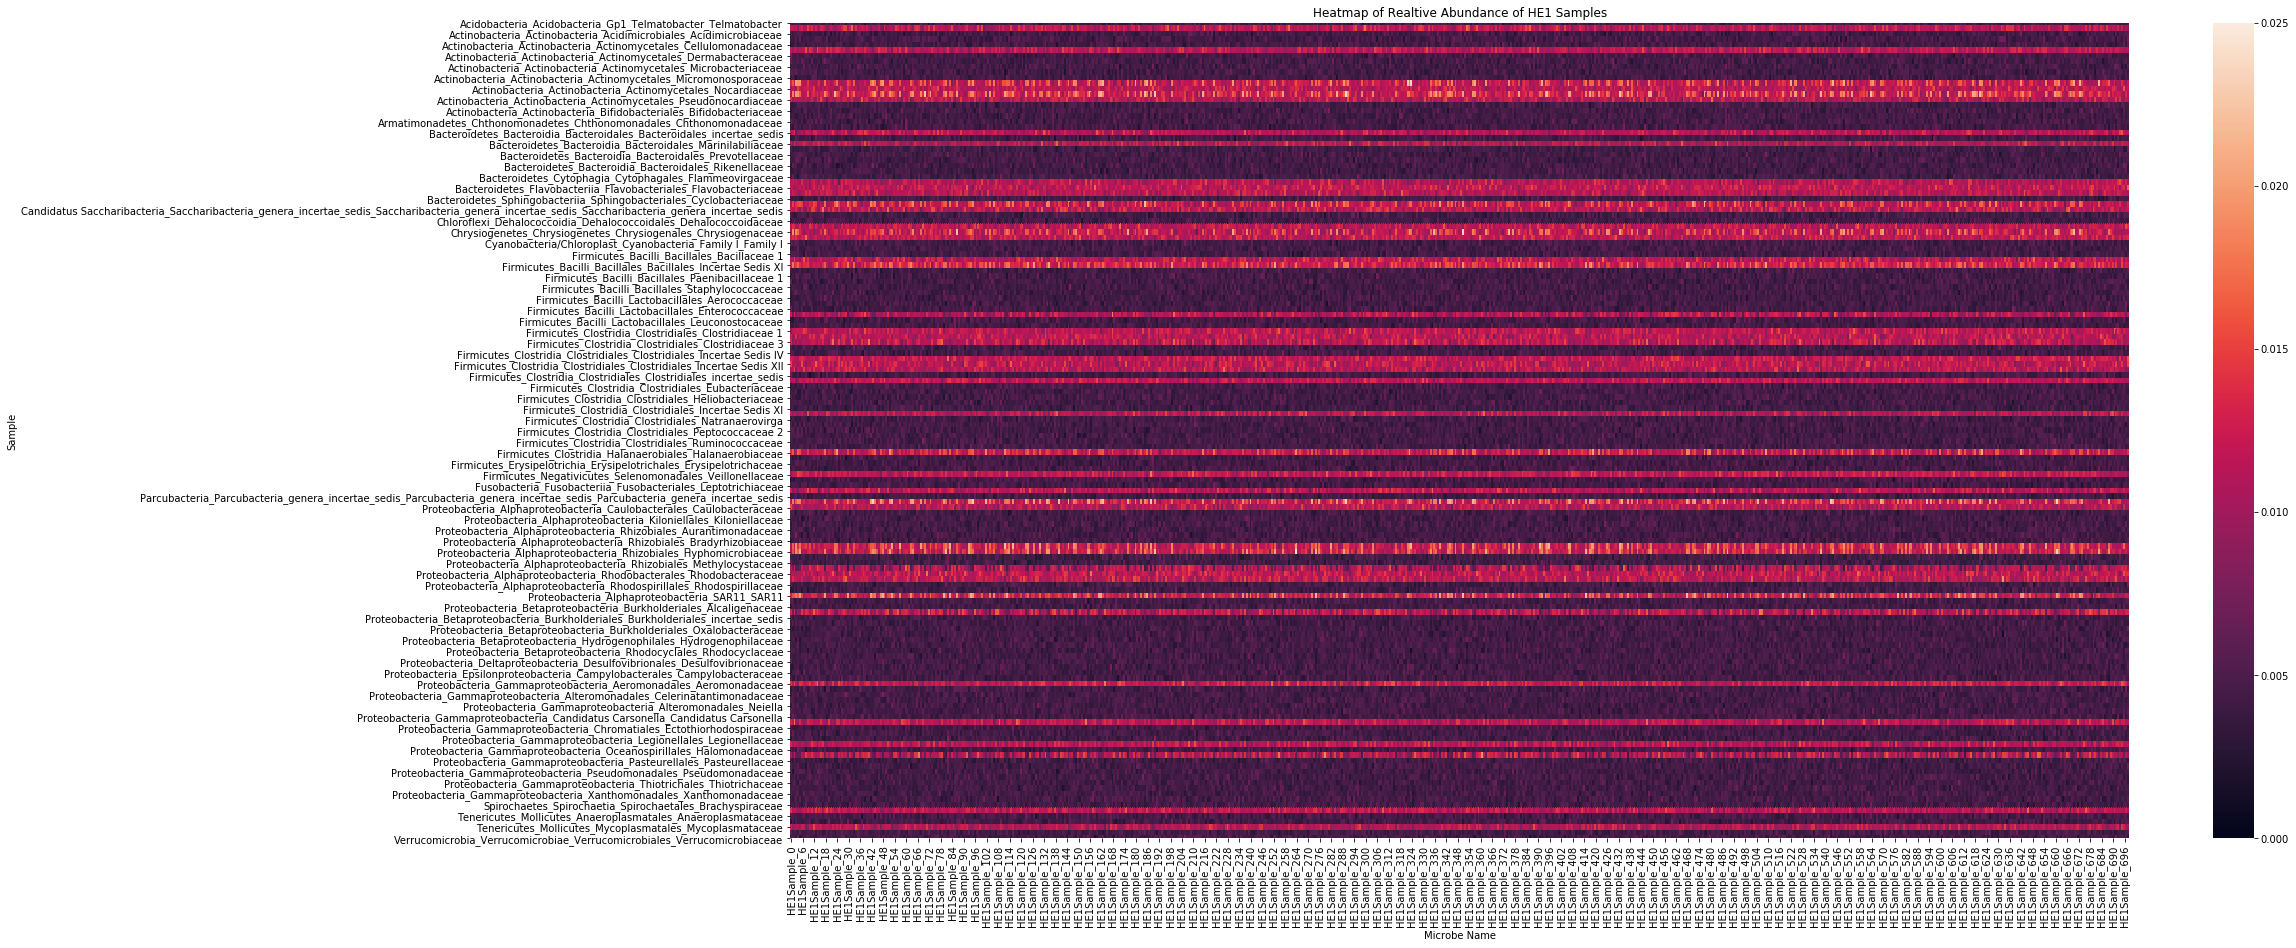

In [23]:
# Plot heatmap for HE1 samples

fig1, ax1 = plt.subplots(figsize = (30, 15))
sns.heatmap(RelativeAbundance_HE1Df.set_index("Microbe Name"), vmin = 0, vmax = 0.025)
#sns.heatmap(RelativeAbundance_HE1Df.iloc[:, 1:].transpose(), vmin = 0, vmax = 0.025, xticklabels = RelativeAbundance_HE1Df["Microbe Name"], ax = ax1)
ax1.set_title("Heatmap of Realtive Abundance of HE1 Samples")
ax1.set_xlabel("Microbe Name")
ax1.set_ylabel("Sample")

# save plot to image file
plt.savefig("RelativeAbundanceHE1_Heatmap.png")

$\textbf{Observations}$

Across both the HE0 samples and the HE1 samples, there appears to be a set of microbes that have a higher relative abundance than the rest of the microbes within each sample. Between the HE0 and HE1 datatsets, microbes with lower relative abundances (the microbes with darker squares overall) don't seem to have very different values for relative abundance. The microbes with higher relative abundances (the microbes with lighter squares overall) within the HE1 dataset have certain microbes in particular samples that have much higher relative abundance values than their counterparts in the HE0 dataset, as indicated by the squares with much lighter colors present in the HE1 dataset. 

$\textbf{Benefits and Drawbacks of Using Heatmaps}$

The heatmaps are good at highlighting the differences between relative abundances; these differences are easy to visualize between light and dark colored cells. As such, it is easy to identify which microbes have samples that have relatively high relative abundances. Examining the precise differences between samples is difficult; it is hard to determine the precise value of each cell just by looking at the figure.

# Task 2: Statistical Analysis

## 1. Kolmogorov-Smirnov (KS) Test

### a. p-value for Two-Sample KS Test

In [15]:
from scipy import stats

In [16]:
len(RelativeAbundance_HE0Df)

149

In [17]:
RelativeAbundance_HE0Df["Microbe Name"][0]

'Acidobacteria_Acidobacteria_Gp1_Telmatobacter_Telmatobacter'

In [18]:
p_values = [] #creating array for all P-values
microbe_names = []

for i in range(RelativeAbundance_HE0Df.shape[0]):
    p = stats.ks_2samp(RelativeAbundance_HE0Df.iloc[i, 1:], RelativeAbundance_HE1Df.iloc[i, 1:])
    p_values.append(p[1])
    microbe_names.append(RelativeAbundance_HE0Df["Microbe Name"][i])

p_values = pd.DataFrame(p_values)

In [19]:
p_values

,0
0,0.180486
1,0.002664
2,0.110367
3,0.540633
4,0.937428
...,...
144,0.125354
145,0.064432
146,0.022486
147,0.763006


### b. Null Hypothesis of the KS Test in our Context

**NULL**: There is no statistically significant difference in abundance of a microbe between samples with Hepatic Encephalopathy and those without Hepatic Encephalopathy  

For example, the microbe Acidobacteria_Acidobacteria_Gp1_Telmatobacter_Telmatobacter has a P-value of 0.18. Assuming our cut off to be .05, we would not have enough evidence to reject the null and thus conclude that there is no statistically significant difference in abundance of Acidobacteria_Acidobacteria_Gp1_Telmatobacter_Telmatobacter in patients with HE and in patients without HE

### c. Number of Genes with Significantly Altered Expression at Various Alpha Values

In [20]:
p_values[0]

0      0.180486
1      0.002664
2      0.110367
3      0.540633
4      0.937428
         ...   
144    0.125354
145    0.064432
146    0.022486
147    0.763006
148    0.804847
Name: 0, Length: 149, dtype: float64

In [21]:
alpha1 = 0
alpha05 = 0
alpha01 = 0
alpha005 = 0
alpha001 = 0

for i in p_values[0]:
    if i < .1:
        alpha1 += 1
    if i < .05:
        alpha05 += 1
    if i < .01:
        alpha01 += 1
    if i < .005:
        alpha005 += 1
    if i < .001:
        alpha001 += 1
        
        
alpha = [.1, .05, .01, .005, .001]
counts = [alpha1, alpha05, alpha01, alpha005, alpha001]

In [22]:
table = pd.DataFrame(
    {'Alpha': alpha,
     'Counts': counts
    })

In [23]:
table

,Alpha,Counts
0,0.100,50
1,0.050,37
2,0.010,27
3,0.005,26
4,0.001,21


## 2. Multiple Testing

### a. P-value

A p-value of 0.05 represents a 5% probability to observe the level of difference in abundance between the two samples that we did or more extreme under the assumption that the HE0 and HE1 samples are statistically similar.

### b. P-value Distribution

Based on the definition of p-value, if the null hypothesis is true, then the p-values will follow a uniform(0,1) distribution.

### c. Expected Number of Significant p-values

In [24]:
import numpy as np 

In [25]:
ecounts = []
alpha = [.1, .05, .01, .005, .001]
for i in range(0, len(alpha)):
    ecounts.append(alpha[i]*149)

comparisonptable = pd.DataFrame(
    {'Alpha': alpha,
     'ObsCounts': counts,
     'ExpCounts': ecounts
    })
comparisonptable

,Alpha,ObsCounts,ExpCounts
0,0.100,50,14.900
1,0.050,37,7.450
2,0.010,27,1.490
3,0.005,26,0.745
4,0.001,21,0.149


### d. Q-Q plot of p-values

#### i. 

In [26]:
expected_p_values = pd.DataFrame(np.random.uniform(0,1,149))

#### ii. 

In [27]:
import math
log_expected_p_values = expected_p_values[0].apply(math.log10)
log_observed_p_values = p_values[0].apply(math.log10)
log_expected_p_values = log_expected_p_values * -1
log_observed_p_values = log_observed_p_values * -1

#### iii. 

In [28]:
sorted_log_expected_p_values = log_expected_p_values.sort_values().reset_index()
sorted_log_observed_p_values = log_observed_p_values.sort_values().reset_index()


#### iv. 

In [29]:
import matplotlib.pyplot as plt

Text(0.5, 0.98, 'Q-Q Plot')

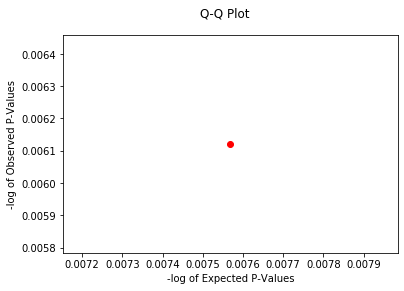

In [30]:
x = sorted_log_expected_p_values[0][0]
y = sorted_log_observed_p_values[0][0]
fig = plt.figure()
ax = plt.plot(x,y, 'ro')
plt.xlabel('-log of Expected P-Values')
plt.ylabel('-log of Observed P-Values')
plt.suptitle('Q-Q Plot')

#### v. 

Text(0.5, 0.98, 'Q-Q Plot')

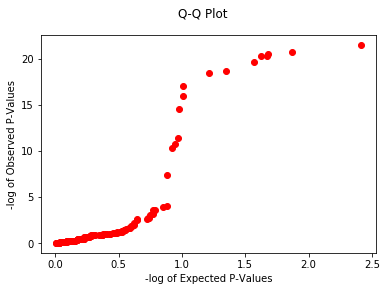

In [31]:
x = sorted_log_expected_p_values[0]
y = sorted_log_observed_p_values[0]
plt.plot(x,y, 'ro')
plt.xlabel('-log of Expected P-Values')
plt.ylabel('-log of Observed P-Values')
plt.suptitle('Q-Q Plot')


#### vi. 

Text(0.5, 0.98, 'Q-Q Plot')

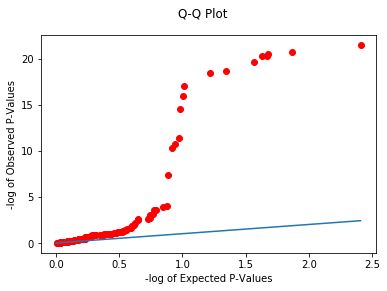

In [32]:
x = sorted_log_expected_p_values[0]
y = sorted_log_observed_p_values[0]
plt.plot(x,y,'ro')
x1 = [0,sorted_log_expected_p_values[0][148]]
x2 = [0,sorted_log_expected_p_values[0][148]]
plt.plot(x2,x2,'-')
plt.xlabel('-log of Expected P-Values')
plt.ylabel('-log of Observed P-Values')
plt.suptitle('Q-Q Plot')

### e. Follow-up Questions

#### i. 

The –log10() transformation is  1 to 1 and monotone that puts larger distance between values close to 0, while changing values close to 1 not as much. This therefore accentuates the difference between small p-values (which are associated with statistically different germs), while not making difference from statistical indifference (from large p-values).  Thus, differences in samples are accentuated and similarities are kept similar. These differences in small-p-values are seen at the right end of the plot, becuase -log10() is monotone decreasing.


#### ii. 

Because the points greatly deviate from the y=x line, which if the points were similar would straddle, we can conclude that the two groups are very different.  Also, because when the points stray from the y=x line, they tend upward, indicate that the observed p-values are weighted more toward smaller p-values than the group of p-values under the assumption that the null hypothesis was true.  

# Task 3: Dimensionality Reduction and Clustering

## 1. PCA

### a. Performing PCA

a. Treating microbes as features (dimensions), perform PCA on the relative abundance
data. (Hint: make use of the decomposition.PCA API in the sklearn package. Select “full”
for svd_solver.)

In [33]:
from sklearn.decomposition import PCA
RelativeAbundance_HE0Df

,Microbe Name,HE0Sample_0,HE0Sample_1,HE0Sample_2,HE0Sample_3,HE0Sample_4,HE0Sample_5,HE0Sample_6,HE0Sample_7,HE0Sample_8,...,HE0Sample_689,HE0Sample_690,HE0Sample_691,HE0Sample_692,HE0Sample_693,HE0Sample_694,HE0Sample_695,HE0Sample_696,HE0Sample_697,HE0Sample_698
0,Acidobacteria_Acidobacteria_Gp1_Telmatobacter_...,0.004239,0.004345,0.004423,0.004463,0.005372,0.004136,0.004457,0.004049,0.004638,...,0.004681,0.005588,0.004256,0.003755,0.004995,0.006198,0.006096,0.003961,0.003970,0.005229
1,Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3,0.013269,0.012312,0.011611,0.013033,0.013689,0.012752,0.009772,0.012148,0.013743,...,0.007489,0.011874,0.011103,0.014661,0.009301,0.010331,0.012716,0.011195,0.011731,0.014642
2,Actinobacteria_Actinobacteria_Acidimicrobiales...,0.003502,0.005251,0.006082,0.003749,0.004332,0.004136,0.004972,0.004930,0.004638,...,0.005055,0.002095,0.005736,0.004291,0.006545,0.004132,0.004877,0.004823,0.001985,0.004532
3,Actinobacteria_Actinobacteria_Actinomycetales_...,0.003870,0.005794,0.005345,0.004106,0.002946,0.003963,0.005315,0.003697,0.005326,...,0.004306,0.003318,0.004626,0.004112,0.004823,0.005447,0.004877,0.003961,0.003609,0.003486
4,Actinobacteria_Actinobacteria_Actinomycetales_...,0.004976,0.003802,0.004239,0.004285,0.005198,0.004136,0.003257,0.002993,0.003264,...,0.005242,0.002445,0.005736,0.005006,0.004306,0.004884,0.002613,0.004650,0.005234,0.004183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,Tenericutes_Mollicutes_Anaeroplasmatales_Anaer...,0.004792,0.003983,0.004976,0.004285,0.003985,0.003963,0.003429,0.005458,0.005154,...,0.003370,0.005762,0.003516,0.004291,0.005167,0.004508,0.002961,0.005512,0.003970,0.003486
145,Tenericutes_Mollicutes_Haloplasmatales_Halopla...,0.004976,0.004345,0.004792,0.007499,0.004332,0.003274,0.004286,0.004930,0.003951,...,0.004306,0.003143,0.003516,0.005364,0.003445,0.005447,0.004355,0.004306,0.005414,0.003660
146,Tenericutes_Mollicutes_Mycoplasmatales_Mycopla...,0.013638,0.010139,0.011611,0.010891,0.009184,0.009478,0.013544,0.014261,0.012541,...,0.014604,0.011524,0.013138,0.013231,0.008612,0.010706,0.010625,0.009645,0.012272,0.008192
147,Thermodesulfobacteria_Thermodesulfobacteria_Th...,0.003870,0.003802,0.004423,0.003571,0.004159,0.004825,0.004972,0.003345,0.004810,...,0.006366,0.004365,0.004626,0.004827,0.005856,0.003757,0.004180,0.002756,0.004512,0.004009


In [34]:
HE0_X = RelativeAbundance_HE0Df.iloc[:,1:].values.transpose()
HE1_X = RelativeAbundance_HE1Df.iloc[:,1:].values.transpose()

PCA_HE0 = PCA(svd_solver = "full").fit(HE0_X)
PCA_HE1 = PCA(svd_solver = "full").fit(HE1_X)

PCA_HE0_Trans = PCA(svd_solver = "full").fit_transform(HE0_X)
PCA_HE1_Trans = PCA(svd_solver = "full").fit_transform(HE1_X)

In [35]:
PCA_HE0.components_

array([[ 0.02708583, -0.27209519,  0.02921411, ...,  0.01241346,
         0.03428822,  0.04823499],
       [ 0.02368855, -0.11275225, -0.04408756, ...,  0.26686045,
         0.00534046, -0.00557399],
       [ 0.0300866 , -0.03192389,  0.02924745, ..., -0.20209567,
         0.01221385,  0.01080152],
       ...,
       [ 0.00739074, -0.00205493, -0.23256405, ..., -0.01644143,
         0.05045924, -0.00840309],
       [-0.005061  ,  0.01749053,  0.00286574, ...,  0.0010903 ,
         0.13420949,  0.03049928],
       [-0.08192319, -0.08192319, -0.08192319, ..., -0.08192319,
        -0.08192319, -0.08192319]])


### b. Ordering Components

In [36]:
import numpy as np

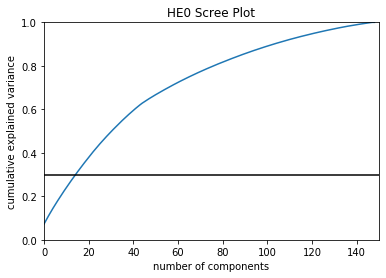

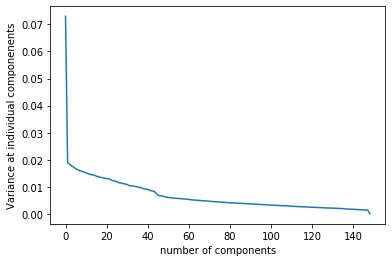

about 15 components are needed to explain 30% of the total variance


In [37]:
#pca = PCA().fit(X_std)
plt.plot(np.cumsum(PCA_HE0.explained_variance_ratio_))
plt.xlim([0,150])
plt.ylim([0,1])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("HE0 Scree Plot")
plt.axhline(0.3, color = 'black')
plt.show()

plt.plot(PCA_HE0.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('Variance at individual componenents')
plt.show()

comp_needed_HE0 = sum(np.cumsum(PCA_HE0.explained_variance_ratio_) <= .3)
print("about " + str(comp_needed_HE0) + " components are needed to explain 30% of the total variance")

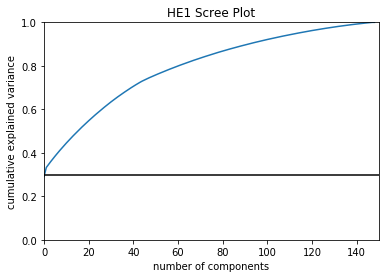

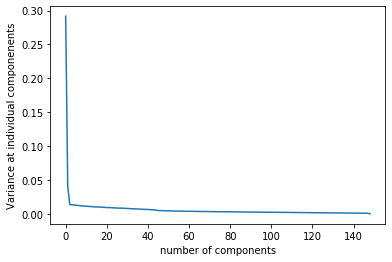

about 1 components are needed to explain 30% of the total variance


In [38]:
plt.plot(np.cumsum(PCA_HE1.explained_variance_ratio_))
plt.xlim([0,150])
plt.ylim([0,1])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("HE1 Scree Plot")
plt.axhline(0.3, color = 'black')
plt.show()

plt.plot(PCA_HE1.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('Variance at individual componenents')
plt.show()

###LOOK AT THIS PLS

comp_needed_HE1 = sum(np.cumsum(PCA_HE1.explained_variance_ratio_) <= .3)
print("about " + str(comp_needed_HE1) + " components are needed to explain 30% of the total variance")

### c. Scatter Plot of Microbe Abundance

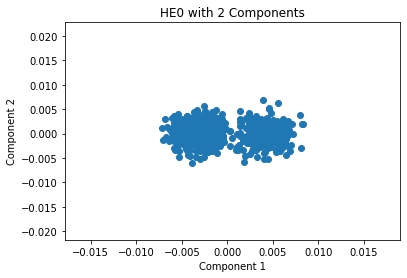

In [39]:
plt.scatter(PCA_HE0_Trans[:,0], PCA_HE0_Trans[:,1])
plt.title('HE0 with 2 Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

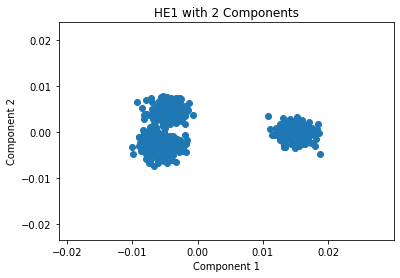

In [40]:
plt.scatter(PCA_HE1_Trans[:,0], PCA_HE1_Trans[:,1])
plt.title('HE1 with 2 Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

It's clear there is clustering. There are two clusters for the HE0 dataset and three clusters for the HE1 dataset. 

## 2. t-SNE

### a. Performing t-SNE

Using the given samples and treating microbe abundances as features (dimensions),
perform t-SNE to visualize the data in 2D. (Hint: make use of the manifold.TSNE API in
the scikit-learn package with parameter random_state=42) t-SNE and plotting should
be done for HE0 samples and HE1 samples separately. Repeat the same t-SNE and 
ECE/CS 498 DS Spring 2020
plotting using the values 62 and 82 for random_state. Briefly summarize your
observations.


In [41]:
from sklearn.manifold import TSNE

In [42]:
TSNE_HE0_42 = TSNE(random_state = 42).fit_transform(HE0_X)
TSNE_HE0_62 = TSNE(random_state = 62).fit_transform(HE0_X)
TSNE_HE0_82 = TSNE(random_state = 82).fit_transform(HE0_X)

TSNE_HE1_42 = TSNE(random_state = 42).fit_transform(HE1_X)
TSNE_HE1_62 = TSNE(random_state = 62).fit_transform(HE1_X)
TSNE_HE1_82 = TSNE(random_state = 82).fit_transform(HE1_X)

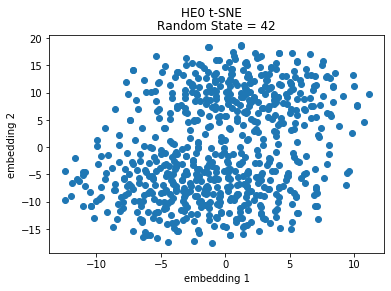

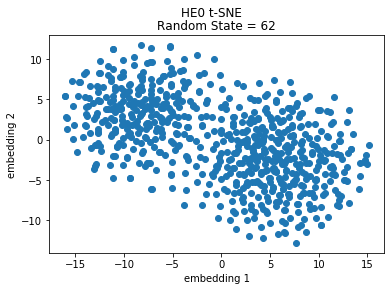

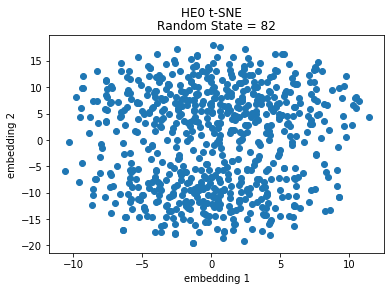

In [43]:
plt.scatter(TSNE_HE0_42[:,0],TSNE_HE0_42[:,1])
plt.suptitle("HE0 t-SNE")
plt.title("Random State = 42")
plt.xlabel("embedding 1")
plt.ylabel("embedding 2")
plt.show()

plt.scatter(TSNE_HE0_62[:,0],TSNE_HE0_62[:,1])
plt.suptitle("HE0 t-SNE")
plt.title("Random State = 62")
plt.xlabel("embedding 1")
plt.ylabel("embedding 2")
plt.show()

plt.scatter(TSNE_HE0_82[:,0],TSNE_HE0_82[:,1])
plt.suptitle("HE0 t-SNE")
plt.title("Random State = 82")
plt.xlabel("embedding 1")
plt.ylabel("embedding 2")
plt.show()

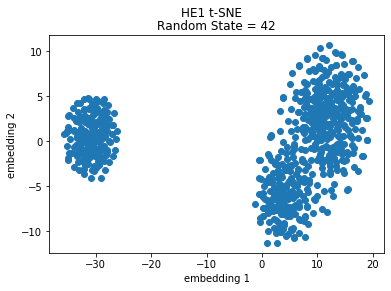

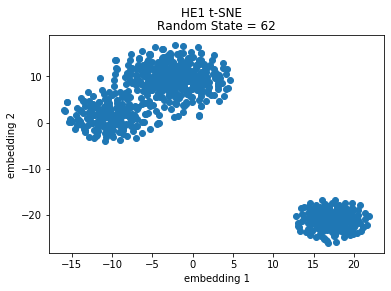

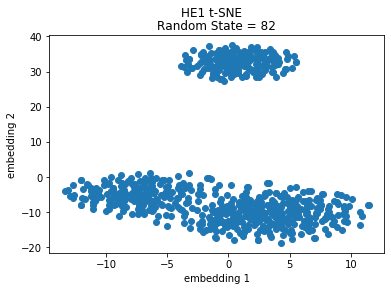

In [44]:
plt.scatter(TSNE_HE1_42[:,0],TSNE_HE1_42[:,1])
plt.suptitle("HE1 t-SNE")
plt.title("Random State = 42")
plt.xlabel("embedding 1")
plt.ylabel("embedding 2")
plt.show()

plt.scatter(TSNE_HE1_62[:,0],TSNE_HE1_62[:,1])
plt.suptitle("HE1 t-SNE")
plt.title("Random State = 62")
plt.xlabel("embedding 1")
plt.ylabel("embedding 2")
plt.show()

plt.scatter(TSNE_HE1_82[:,0],TSNE_HE1_82[:,1])
plt.suptitle("HE1 t-SNE")
plt.title("Random State = 82")
plt.xlabel("embedding 1")
plt.ylabel("embedding 2")
plt.show()

t-SNE runs much slower than PCA. We also see the same amount of clusters being formed as we saw in PCA. These plots also change depending on the random state.

### b. Comparing with PCA

For both the HE0 and HE1 datasets, both PCA and t-SNE appear to have two clusters for the HE0 data and three clusters for the HE1 data (in the HE1 visualizations for both methods, there appear to be two adjacent clusters with one cluster that is separated). In terms of differences, the t-SNE visualizations seem to have different orientations of the clusters and greater spread between points than the PCA visualizations depending on what random state was used for t-SNE. Also, PCA performs much faster than t-SNE in our analysis.

## 3. Clustering

### a. K-Means

In [45]:
from sklearn.cluster import KMeans

In [46]:
kmeans_HE0 = KMeans(n_clusters=2, random_state= 42).fit(PCA_HE0_Trans)
kmeans_HE0_color = kmeans_HE0.fit_predict(PCA_HE0_Trans)

kmeans_HE1 = KMeans(n_clusters=3, random_state= 42).fit(PCA_HE1_Trans)
kmeans_HE1_color = kmeans_HE1.fit_predict(PCA_HE1_Trans)

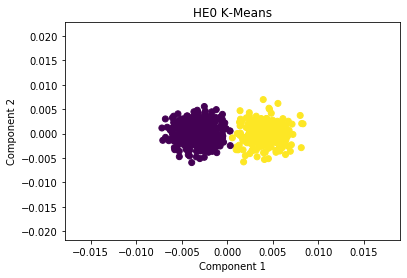

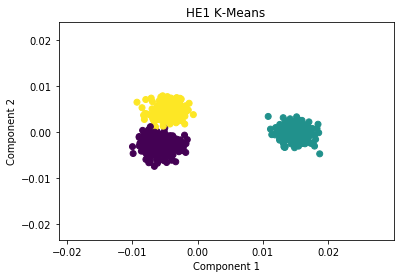

In [47]:
plt.scatter(PCA_HE0_Trans[:,0],PCA_HE0_Trans[:,1],c=kmeans_HE0_color)
plt.title("HE0 K-Means")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

plt.scatter(PCA_HE1_Trans[:,0],PCA_HE1_Trans[:,1],c=kmeans_HE1_color)
plt.title("HE1 K-Means")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()



### b. GMM

In [48]:
from sklearn import mixture

In [49]:
#MULTIPLY DATASET BY 1000 

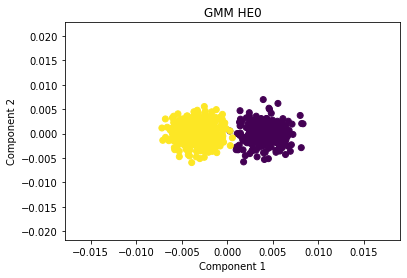

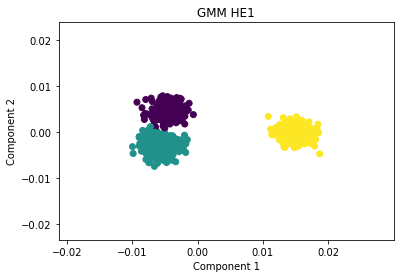

In [50]:
gmm_HE0 = mixture.GaussianMixture(n_components=2).fit(PCA_HE0_Trans)
gmm_HE0_colors = gmm_HE0.predict(PCA_HE0_Trans)
plt.scatter(PCA_HE0_Trans[:, 0], PCA_HE0_Trans[:, 1], c=gmm_HE0_colors);
plt.title("GMM HE0")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

gmm_HE1 = mixture.GaussianMixture(n_components=3).fit(PCA_HE1_Trans)
gmm_HE1_colors = gmm_HE1.predict(PCA_HE1_Trans)
plt.scatter(PCA_HE1_Trans[:, 0], PCA_HE1_Trans[:, 1], c=gmm_HE1_colors);
plt.title("GMM HE1")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

### c. Single and Complete Linkage Hierarchical

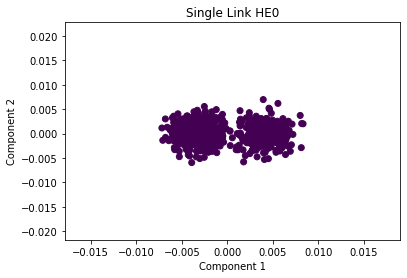

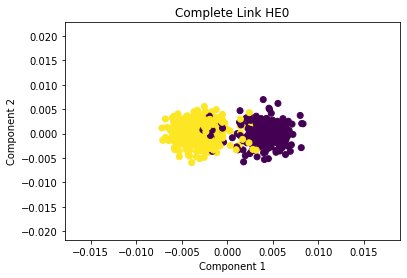

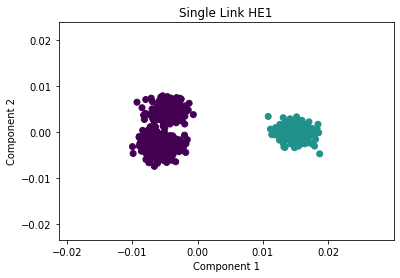

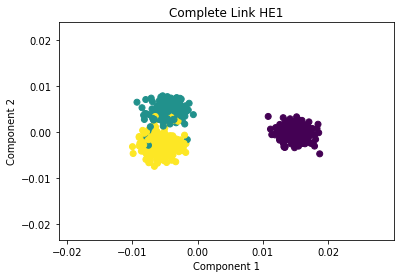

In [51]:
#Single LInk HE0
from sklearn.cluster import AgglomerativeClustering
higheraricahal_singlelink_HE0 = AgglomerativeClustering(n_clusters=2 , linkage = 'single').fit(PCA_HE0_Trans)
higheraricahal_singlelink_HE0_color = higheraricahal_singlelink_HE0.fit_predict(PCA_HE0_Trans)
plt.scatter(PCA_HE0_Trans[:, 0], PCA_HE0_Trans[:, 1], c = higheraricahal_singlelink_HE0_color);
plt.title("Single Link HE0")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

#Complete LInk HE0
higheraricahal_singlelink_HE0 = AgglomerativeClustering(n_clusters=2 , linkage = 'complete').fit(PCA_HE0_Trans)
higheraricahal_singlelink_HE0_color = higheraricahal_singlelink_HE0.fit_predict(PCA_HE0_Trans)
plt.scatter(PCA_HE0_Trans[:, 0], PCA_HE0_Trans[:, 1], c = higheraricahal_singlelink_HE0_color);
plt.title("Complete Link HE0")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

#Single LInk HE1
from sklearn.cluster import AgglomerativeClustering
higheraricahal_singlelink_HE1 = AgglomerativeClustering(n_clusters=3 , linkage = 'single').fit(PCA_HE1_Trans)
higheraricahal_singlelink_HE1_color = higheraricahal_singlelink_HE1.fit_predict(PCA_HE1_Trans)
plt.scatter(PCA_HE1_Trans[:, 0], PCA_HE1_Trans[:, 1], c = higheraricahal_singlelink_HE1_color);
plt.title("Single Link HE1")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()



#Complete LInk HE1
from sklearn.cluster import AgglomerativeClustering
higheraricahal_singlelink_HE1 = AgglomerativeClustering(n_clusters=3 , linkage = 'complete').fit(PCA_HE1_Trans)
higheraricahal_singlelink_HE1_color = higheraricahal_singlelink_HE1.fit_predict(PCA_HE1_Trans)
plt.scatter(PCA_HE1_Trans[:, 0], PCA_HE1_Trans[:, 1], c = higheraricahal_singlelink_HE1_color);
plt.title("Complete Link HE1")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()





### d. Single vs Complete Link Hierarchical Clustering

Discuss the differences between the single and complete linkage hierarchical clustering
methods. Do you see any major differences in the generated clusters? Is there anything
about our data which affects if we see a difference between the two linkage options?

The biggest difference between these two clustering methods is the sensitivity to outliers. Its shown here in both cases where Complete Link creates much more defined clusters than single link.

### e. Comparing Clustering Techniques

All of the clustering methods preform rather similarly to each other except the single link hierarchical clustering method.  

Since K-means, GMM, and Complete Link preform similairly to each other, the best method here would be K-means as it is much simpler than GMM and Complete Link.   

The "biggest" difference between these three methods is the type of clustering, Hard or Soft.

### f. What do Clusters Represent

Clusters were formed based on how close samples' microbe abundunce profiles are. Thus, each cluster formed represents a subpopulation of the samples such that the samples in each subpopulation have silimar microbe abundance. Biological factors can explain why the clusters formed in the way that they did. This can include the severity of the cirrhosis in each patient. For instance, one cluster could represent samples of patients with a more severe case of cirrhosis than the rest of the patients which in turn may have caused their microbe abundance profiles to be different. Other biological factors to consider that may have affected the clustering pattern could include different age groups for each patient, patient diet, etc.

### g. Deciding on Number of Clusters

If two clusters are nested within each other, it is possible that our process treats these clusters as one cluster instead of two, leading to an inaccurate number of clusters. Also, it is possible that our process splits clusters that actually have large radii and merges clusters with small radii, which would also lead to an inaccurate cluster number.

# Task 4: Interpreting Results

## 1. Identify Microbes with Altered Abundance Levels

### a. Determine if each HE1 Subpopulation shows altered abundance levels

To get the clusters, I will first splice the HE1 and HE0 sample data by the coloring data. Then, I will tranpsose the data such that the data forms and array of relative microbe abundance. To determine significantly altered relative abundances, I will find the percent difference between the subpopulation relative microbe abundance means for each microbe and for each combination between the subpopulations in HE1 and the subpopulations in HE0. The threshold to determine significance will be determined from the comparison of the two HE0 subpopulations. Comparisons with more percent difference than that between the two HE0 populations will be significantly different.

In [52]:
# to determine altered relative abundance levels, I will use the KS 2 sample test on the relative 
#abundance of a certain microbe in HE0 and the relative abundance of the pertanent microbe in the 
#various clusters, repeating for every cluster, and for every microbe.

# Sorting HE1 sample relative abundances into clusters
HE1_cluster0 = []
HE1_cluster1 = []
HE1_cluster2 = []
for i in range(0, len(gmm_HE1_colors)):
    if kmeans_HE1_color[i] == 0:
        HE1_cluster0.append(HE1_X[i])
    if kmeans_HE1_color[i] == 1:
        HE1_cluster1.append(HE1_X[i])
    if kmeans_HE1_color[i] == 2:
        HE1_cluster2.append(HE1_X[i])
# Transposing array to have arrays by microbe relative abundance.
HE1_cluster0 = pd.DataFrame(np.array(HE1_cluster0)).values.transpose()
HE1_cluster1 = pd.DataFrame(np.array(HE1_cluster1)).values.transpose()
HE1_cluster2 = pd.DataFrame(np.array(HE1_cluster2)).values.transpose()

#Doing the same with HE0 clusters.
HE0_cluster0 = []
HE0_cluster1 = []
for i in range(0, len(gmm_HE0_colors)):
    if kmeans_HE0_color[i] == 0:
        HE0_cluster0.append(HE0_X[i])
    if kmeans_HE0_color[i] == 1:
        HE0_cluster1.append(HE0_X[i])
# Transposing array to have arrays by microbe relative abundance.
HE0_cluster0 = pd.DataFrame(np.array(HE0_cluster0)).values.transpose()
HE0_cluster1 = pd.DataFrame(np.array(HE0_cluster1)).values.transpose()

#getting means
HE1_cluster0_avg = []
HE1_cluster1_avg = []
HE1_cluster2_avg = []
HE0_cluster0_avg = []
HE0_cluster1_avg = []
for i in range(0, len(HE1_cluster0)):
    HE1_cluster0_avg.append(np.mean(HE1_cluster0[i]))
    HE1_cluster1_avg.append(np.mean(HE1_cluster1[i]))
    HE1_cluster2_avg.append(np.mean(HE1_cluster2[i]))
    HE0_cluster0_avg.append(np.mean(HE0_cluster0[i]))
    HE0_cluster1_avg.append(np.mean(HE0_cluster1[i]))

#Percent diff of means
HE1_cl0_vs_HE0_cl0_pdiff = []
HE1_cl0_vs_HE0_cl1_pdiff = []
HE1_cl1_vs_HE0_cl0_pdiff = []
HE1_cl1_vs_HE0_cl1_pdiff = []
HE1_cl2_vs_HE0_cl0_pdiff = []
HE1_cl2_vs_HE0_cl1_pdiff = []
for i in range(0, len(HE1_cluster0_avg)):
    HE1_cl0_vs_HE0_cl0_pdiff.append(abs(HE1_cluster0_avg[i]-HE0_cluster0_avg[i])/(0.5*(HE1_cluster0_avg[i]+HE0_cluster0_avg[i])))
    HE1_cl0_vs_HE0_cl1_pdiff.append(abs(HE1_cluster0_avg[i]-HE0_cluster1_avg[i])/(0.5*(HE1_cluster0_avg[i]+HE0_cluster1_avg[i])))
    HE1_cl1_vs_HE0_cl0_pdiff.append(abs(HE1_cluster1_avg[i]-HE0_cluster0_avg[i])/(0.5*(HE1_cluster1_avg[i]+HE0_cluster0_avg[i])))
    HE1_cl1_vs_HE0_cl1_pdiff.append(abs(HE1_cluster1_avg[i]-HE0_cluster1_avg[i])/(0.5*(HE1_cluster1_avg[i]+HE0_cluster1_avg[i])))
    HE1_cl2_vs_HE0_cl0_pdiff.append(abs(HE1_cluster2_avg[i]-HE0_cluster0_avg[i])/(0.5*(HE1_cluster2_avg[i]+HE0_cluster0_avg[i])))
    HE1_cl2_vs_HE0_cl1_pdiff.append(abs(HE1_cluster2_avg[i]-HE0_cluster1_avg[i])/(0.5*(HE1_cluster2_avg[i]+HE0_cluster1_avg[i])))

Text(0, 0.5, 'Percent Differences')

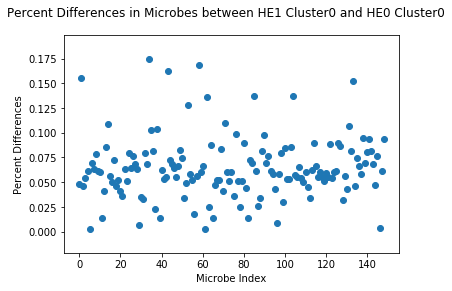

In [53]:
HE0_cl0_vs_HE0_cl1_pdiff = []
for i in range(0, len(HE0_cluster1_avg)):
    HE0_cl0_vs_HE0_cl1_pdiff.append(abs(HE0_cluster1_avg[i]-HE0_cluster0_avg[i])/(0.5*(HE0_cluster1_avg[i]+HE0_cluster0_avg[i])))
plt.scatter(range(0,149),HE0_cl0_vs_HE0_cl1_pdiff)
plt.suptitle('Percent Differences in Microbes between HE1 Cluster0 and HE0 Cluster0')
plt.xlabel('Microbe Index')
plt.ylabel('Percent Differences')

Text(0, 0.5, 'Percent Differences')

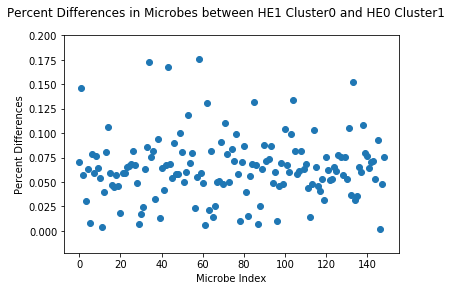

In [54]:
plt.scatter(range(0,149),HE1_cl0_vs_HE0_cl1_pdiff)
plt.suptitle('Percent Differences in Microbes between HE1 Cluster0 and HE0 Cluster1')
plt.xlabel('Microbe Index')
plt.ylabel('Percent Differences')

Text(0, 0.5, 'Percent Differences')

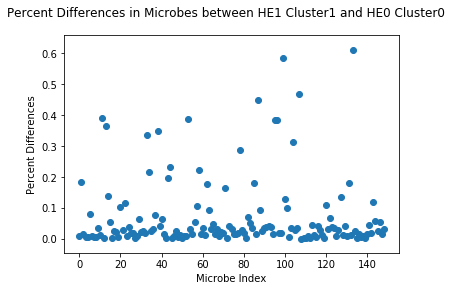

In [55]:
plt.scatter(range(0,149),HE1_cl1_vs_HE0_cl0_pdiff)
plt.suptitle('Percent Differences in Microbes between HE1 Cluster1 and HE0 Cluster0')
plt.xlabel('Microbe Index')
plt.ylabel('Percent Differences')

Text(0, 0.5, 'Percent Differences')

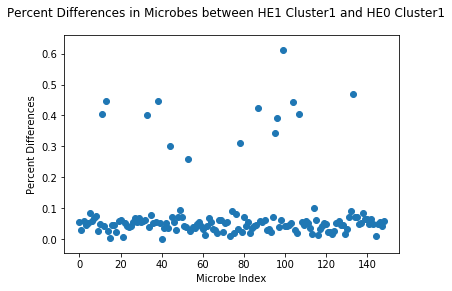

In [56]:
plt.scatter(range(0,149),HE1_cl1_vs_HE0_cl1_pdiff)
plt.suptitle('Percent Differences in Microbes between HE1 Cluster1 and HE0 Cluster1')
plt.xlabel('Microbe Index')
plt.ylabel('Percent Differences')

Text(0, 0.5, 'Percent Differences')

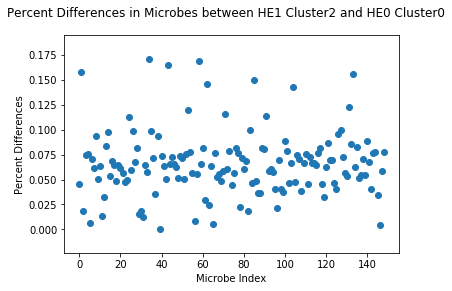

In [57]:
plt.scatter(range(0,149),HE1_cl2_vs_HE0_cl0_pdiff)
plt.suptitle('Percent Differences in Microbes between HE1 Cluster2 and HE0 Cluster0')
plt.xlabel('Microbe Index')
plt.ylabel('Percent Differences')

Text(0, 0.5, 'Percent Differences')

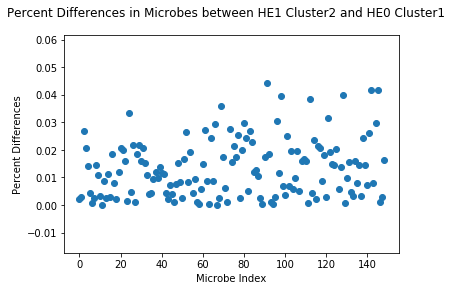

In [58]:
plt.scatter(range(0,149),HE1_cl2_vs_HE0_cl1_pdiff)
plt.suptitle('Percent Differences in Microbes between HE1 Cluster2 and HE0 Cluster1')
plt.xlabel('Microbe Index')
plt.ylabel('Percent Differences')

Looking at the percent differences between both HE0 subpopulations, it can be seen that the upper roof of the percent differences of microbes is close to but below 18%. This will thus be treated as an upper threshhold for significance between HE1 subpopulations and HE0 subpopulations. Looking at the comparisons between HE1 subpopulations and HE0 subpopulations, the only HE1 subpopulation that passes the threshold in any way is HE1 cluster1. 

### b. Identify Samples which Most Closly Resemble each other.

In [59]:
print('Between HE1 cluster1 and HE0 cluster0, there is an average {} percent difference'.format(np.mean(HE1_cl1_vs_HE0_cl0_pdiff)))
print('Between HE1 cluster1 and HE0 cluster1, there is an average {} percent difference'.format(np.mean(HE1_cl0_vs_HE0_cl0_pdiff)))

Between HE1 cluster1 and HE0 cluster0, there is an average 0.07339040814176045 percent difference
Between HE1 cluster1 and HE0 cluster1, there is an average 0.010682397837604943 percent difference


Looking at the average perecent differences between HE1 cluster 1 and the HE0 cluster0 and HE0cluster1, it can be seen that the average percent difference between HE1 cluster1 and HE0 cluster1 is smaller, as it has the smaller average percent difference.

### c. Identify Microbes with Significantly Altered Relative Abundance

In [60]:
HE1_cl1_v_HE0_cl1 = []
HE1_cl1_v_HE0_cl1_sig_idx = []
for i in range(0,len(HE1_cluster1)):
    temp = stats.ks_2samp(HE1_cluster1[i],HE0_cluster1[i])[1]
    HE1_cl1_v_HE0_cl1.append(temp)
    if temp < 0.0000025:
        HE1_cl1_v_HE0_cl1_sig_idx.append(i)

microbenames = RelativeAbundance_HE1Df['Microbe Name'].values
significantly_altered_cluster1 = []
for i in HE1_cl1_v_HE0_cl1_sig_idx:
    significantly_altered_cluster1.append(microbenames[i])

print(significantly_altered_cluster1)

['Actinobacteria_Actinobacteria_Actinomycetales_Corynebacteriaceae', 'Actinobacteria_Actinobacteria_Actinomycetales_Nakamurellaceae', 'Actinobacteria_Actinobacteria_Actinomycetales_Propionibacteriaceae', 'Bacteroidetes_Bacteroidia_Bacteroidales_Bacteroidales_incertae_sedis', 'Bacteroidetes_Flavobacteriia_Flavobacteriales_Cryomorphaceae', 'Bacteroidetes_Sphingobacteriia_Sphingobacteriales_Sphingobacteriaceae', 'Chrysiogenetes_Chrysiogenetes_Chrysiogenales_Chrysiogenaceae', 'Firmicutes_Bacilli_Bacillales_Bacillales_Incertae Sedis XI', 'Firmicutes_Bacilli_Lactobacillales_Lactobacillaceae', 'Firmicutes_Clostridia_Clostridiales_Clostridiales_Incertae Sedis XIII', 'Firmicutes_Clostridia_Halanaerobiales_Halanaerobiaceae', 'Firmicutes_Negativicutes_Selenomonadales_Veillonellaceae', 'Parvarchaeota_Candidatus Parvarchaeum_Candidatus Parvarchaeum_Candidatus Parvarchaeum', 'Proteobacteria_Alphaproteobacteria_Rhizobiales_Brucellaceae', 'Proteobacteria_Alphaproteobacteria_Rhizobiales_Hyphomicrobiace

## 2. Identify How Abundance Changes

### a. Microbes which increase and decrease

To determine which microbes that have significantly changed between the HE0 and HE1 datasets, compare the mean relative abundances between the two datasets for each microbe that have be significantly altered.

In [95]:
sig_dec_micro = []
sig_inc_micro = []

for microbe in significantly_altered_cluster1:
    if (float(RelativeAbundance_HE1Df.loc[RelativeAbundance_HE1Df["Microbe Name"] == microbe].mean(axis=1)) > float(RelativeAbundance_HE0Df.loc[RelativeAbundance_HE0Df["Microbe Name"] == microbe].mean(axis=1))):
        sig_inc_micro.append(microbe)
    else:
        sig_dec_micro.append(microbe)

The following outputs a list of microbes that show increased relative abundance in the HE1 samples.

In [96]:
sig_inc_micro

['Actinobacteria_Actinobacteria_Actinomycetales_Nakamurellaceae',
 'Actinobacteria_Actinobacteria_Actinomycetales_Propionibacteriaceae',
 'Bacteroidetes_Sphingobacteriia_Sphingobacteriales_Sphingobacteriaceae',
 'Chrysiogenetes_Chrysiogenetes_Chrysiogenales_Chrysiogenaceae',
 'Firmicutes_Bacilli_Bacillales_Bacillales_Incertae Sedis XI',
 'Firmicutes_Clostridia_Halanaerobiales_Halanaerobiaceae',
 'Parvarchaeota_Candidatus Parvarchaeum_Candidatus Parvarchaeum_Candidatus Parvarchaeum',
 'Proteobacteria_Alphaproteobacteria_Rhizobiales_Brucellaceae',
 'Proteobacteria_Alphaproteobacteria_Rhizobiales_Hyphomicrobiaceae',
 'Proteobacteria_Alphaproteobacteria_SAR11_SAR11']

The following outputs a list of microbes that show decreased relative abundance in the HE0 samples. 

In [97]:
sig_dec_micro

['Actinobacteria_Actinobacteria_Actinomycetales_Corynebacteriaceae',
 'Bacteroidetes_Bacteroidia_Bacteroidales_Bacteroidales_incertae_sedis',
 'Bacteroidetes_Flavobacteriia_Flavobacteriales_Cryomorphaceae',
 'Firmicutes_Bacilli_Lactobacillales_Lactobacillaceae',
 'Firmicutes_Clostridia_Clostridiales_Clostridiales_Incertae Sedis XIII',
 'Firmicutes_Negativicutes_Selenomonadales_Veillonellaceae',
 'Proteobacteria_Alphaproteobacteria_Rhizobiales_Rhizobiaceae',
 'Proteobacteria_Betaproteobacteria_Burkholderiales_Burkholderiaceae',
 'Proteobacteria_Gammaproteobacteria_Orbales_Orbaceae']

### b. Biological Relations

According to the results generated above, it appears that "Proteobacteria Alphaproteobacteria" bacteria have a grouping in the increased group of microbes.